# Train and test an SVM

## Import boilerplate and setup

In [1]:
# first, change the working directory, if needed
import os
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
os.getcwd()

'/mnt/c/Users/aryam/Documents/school/2020/spring/cse283/BloodBrainClassifier'

In [2]:
# now, import whatever else we need
import sklearn
import pandas as pd
from sklearn.svm import SVC
import scripts.starter as data
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [3]:
%%bash --out selected_genes
Rscript scripts/select_DEgenes.R

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 11119 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [3]:
# selected_genes = 'ENSG00000223062,ENSG00000273274,ENSG00000264698,ENSG00000207328,ENSG00000231485,ENSG00000278281,ENSG00000238256,ENSG00000222209,ENSG00000169291,ENSG00000272262,ENSG00000118873,ENSG00000223119,ENSG00000163803,ENSG00000238448,ENSG00000281071,ENSG00000196975,ENSG00000075292,ENSG00000132300,ENSG00000201070,ENSG00000206718,ENSG00000260742,ENSG00000281192,ENSG00000118997,ENSG00000238827,ENSG00000252976,ENSG00000201545,ENSG00000238672,ENSG00000207625,ENSG00000222719,ENSG00000181555,ENSG00000281824,ENSG00000277939,ENSG00000264477,ENSG00000276656,ENSG00000266857,ENSG00000273789,ENSG00000280919,ENSG00000264114,ENSG00000272707,ENSG00000281359,ENSG00000252307,ENSG00000199894,ENSG00000250945,ENSG00000250835,ENSG00000201264,ENSG00000109654,ENSG00000252702,ENSG00000273742,ENSG00000275686,ENSG00000222743,ENSG00000238508,ENSG00000280673,ENSG00000274992,ENSG00000212114,ENSG00000247627,ENSG00000222924,ENSG00000199880,ENSG00000124588,ENSG00000201048,ENSG00000111913,ENSG00000212240,ENSG00000263926,ENSG00000252767,ENSG00000212468,ENSG00000200224,ENSG00000212017,ENSG00000265498,ENSG00000276064,ENSG00000281602,ENSG00000238490,ENSG00000223191,ENSG00000222869,ENSG00000211691,ENSG00000202350,ENSG00000200130,ENSG00000238391,ENSG00000207045,ENSG00000221510,ENSG00000252047,ENSG00000199764,ENSG00000199224,ENSG00000281656,ENSG00000252811,ENSG00000251728,ENSG00000251936,ENSG00000275790,ENSG00000252294,ENSG00000216098,ENSG00000206661,ENSG00000253437,ENSG00000252210,ENSG00000252057,ENSG00000277929,ENSG00000254212,ENSG00000200525,ENSG00000201627,ENSG00000221793,ENSG00000276479,ENSG00000253043,ENSG00000276961,ENSG00000107099,ENSG00000200941,ENSG00000251748,ENSG00000200106,ENSG00000107263,ENSG00000251934,ENSG00000207252,ENSG00000052841,ENSG00000149177,ENSG00000275344,ENSG00000280605,ENSG00000222663,ENSG00000200849,ENSG00000199407,ENSG00000221221,ENSG00000252639,ENSG00000207135,ENSG00000252132,ENSG00000280779,ENSG00000253012,ENSG00000201047,ENSG00000278752,ENSG00000276694,ENSG00000271508,ENSG00000264906,ENSG00000275770,ENSG00000274124,ENSG00000257570,ENSG00000207381,ENSG00000258173,ENSG00000252823,ENSG00000258224,ENSG00000207365,ENSG00000265861,ENSG00000200483,ENSG00000165474,ENSG00000252247,ENSG00000216014,ENSG00000230243,ENSG00000274190,ENSG00000222733,ENSG00000206854,ENSG00000206800,ENSG00000251753,ENSG00000201847,ENSG00000211827,ENSG00000211837,ENSG00000211864,ENSG00000253059,ENSG00000258966,ENSG00000100767,ENSG00000252013,ENSG00000201097,ENSG00000187621,ENSG00000199390,ENSG00000201500,ENSG00000202293,ENSG00000207208,ENSG00000207568,ENSG00000225825,ENSG00000254045,ENSG00000252326,ENSG00000200120,ENSG00000199784,ENSG00000200873,ENSG00000221309,ENSG00000200677,ENSG00000103275,ENSG00000207248,ENSG00000260688,ENSG00000260067,ENSG00000200437,ENSG00000252383,ENSG00000266416,ENSG00000274054,ENSG00000264314,ENSG00000265218,ENSG00000222548,ENSG00000266988,ENSG00000267327,ENSG00000252097,ENSG00000252096,ENSG00000201363,ENSG00000238452,ENSG00000263903,ENSG00000266104,ENSG00000238364,ENSG00000265879,ENSG00000252177,ENSG00000105499,ENSG00000161671,ENSG00000207734,ENSG00000207803,ENSG00000278335,ENSG00000254240'
selected_genes

'ENSG00000223062,ENSG00000273274,ENSG00000264698,ENSG00000207328,ENSG00000231485,ENSG00000278281,ENSG00000238256,ENSG00000222209,ENSG00000169291,ENSG00000272262,ENSG00000118873,ENSG00000223119,ENSG00000163803,ENSG00000238448,ENSG00000281071,ENSG00000196975,ENSG00000075292,ENSG00000132300,ENSG00000201070,ENSG00000206718,ENSG00000260742,ENSG00000281192,ENSG00000118997,ENSG00000238827,ENSG00000252976,ENSG00000201545,ENSG00000238672,ENSG00000207625,ENSG00000222719,ENSG00000181555,ENSG00000281824,ENSG00000277939,ENSG00000264477,ENSG00000276656,ENSG00000266857,ENSG00000273789,ENSG00000280919,ENSG00000264114,ENSG00000272707,ENSG00000281359,ENSG00000252307,ENSG00000199894,ENSG00000250945,ENSG00000250835,ENSG00000201264,ENSG00000109654,ENSG00000252702,ENSG00000273742,ENSG00000275686,ENSG00000222743,ENSG00000238508,ENSG00000280673,ENSG00000274992,ENSG00000212114,ENSG00000247627,ENSG00000222924,ENSG00000199880,ENSG00000124588,ENSG00000201048,ENSG00000111913,ENSG00000212240,ENSG00000263926,ENSG000

In [4]:
data.data = data.data[selected_genes.split(',') + ['group']]
data.split()
len(data.data.columns)

196

## Train SVC model

In [18]:
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', C=.01))
clf.fit(data.X_train, data.y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=0.01, kernel='linear'))])

## Test SVC model and evaluate the model's performance

In [19]:
y_pred = clf.predict(data.X_test)

In [20]:
clf.score(data.X_test, data.y_test)

0.625

Wow, that's pretty terrible. Is there any way we can improve that?

First, let's ask ourselves what the model might be doing wrong. Let's compare the predictions to the true labels.

In [21]:
pd.concat((data.y_test, pd.Series(y_pred, index=data.y_test.index)), axis=1)

,group,0
sample,,
N_5_06_1,0,1
N_3_03_1,0,1
AD_5_12_1,1,1
AD_8_03_1,1,1
AD_1_13_1,1,1
N_4_06_1,0,0
N_7_07_1,0,1
N_7_01_1,0,1
AD_5_13_1,1,1


In [22]:
clf.decision_function(data.X_test)

array([ 0.44907591,  0.15947969,  0.65392261,  0.45445548,  1.08889972,
       -0.10176362,  0.09936225,  0.90448826,  0.49613348,  0.70044265,
       -0.10612994,  0.26281577, -0.11130883,  0.02214184, -0.34617423,
       -0.2531982 ,  0.40958363,  1.37076311, -0.27419032,  0.55822644,
        0.3145256 ,  0.75994564, -0.23683945,  0.67268193,  0.0117206 ,
        0.1833646 ,  0.20125237,  0.83774116,  0.65928095,  0.62350851,
        1.47002543,  0.16059145])

## Could there be overfitting?
How does our model perform when given all of the data, compared to before?

In [23]:
clf.fit(data.X, data.y)
clf.score(data.X_test, data.y_test)

0.96875

Hmmm.. perhaps

## Are the samples separable to begin with?
Let's take a look at the first two PCs against each other.

In [24]:
from sklearn.decomposition import PCA

<AxesSubplot:xlabel='0', ylabel='1'>

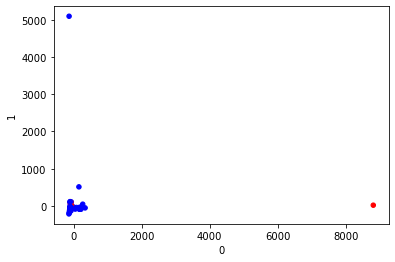

In [26]:
pca = PCA(n_components=2)
X_new = pca.fit_transform(data.X)
pd.DataFrame(X_new).plot.scatter(x=0, y=1, color=['blue' if x else 'red' for x in data.data.group])

In [27]:
from sklearn.model_selection import cross_val_score
clf.fit(data.X_train, data.y_train)
sklearn.model_selection.cross_val_score(clf, data.X, data.y, cv=10)

array([0.92307692, 0.92307692, 0.61538462, 0.92307692, 0.84615385,
       0.69230769, 0.83333333, 0.91666667, 0.83333333, 0.91666667])

In [14]:
X, y, X_train, y_train, X_test, y_test = data.X, data.y, data.X_train, data.y_train, data.X_test, data.y_test

In [32]:
import scripts.grid_search

model = sklearn.svm.SVC()
tuned_parameters = [{'kernel': ['poly'], 'gamma': [1e-7, 1e-8, 1e-10], 'C': [1, 0.000001], 'degree':[5, 6, 7, 8, 9]}]
tuned_parameters = [{'kernel': ['rbf'], 'C': [0.8, 1, 1.5, 2]},
                    {'kernel': ['linear'], 'C': [1, 0.5, 0.1, 0.01]}]

scripts.grid_search.main(
    (data.X_train, data.y_train, data.X_test, data.y_test), SVC(), tuned_parameters
)

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 2, 'kernel': 'rbf'}

Grid scores on development set:

0.776 (+/-0.128) for {'C': 0.8, 'kernel': 'rbf'}
0.820 (+/-0.031) for {'C': 1, 'kernel': 'rbf'}
0.859 (+/-0.077) for {'C': 1.5, 'kernel': 'rbf'}
0.872 (+/-0.086) for {'C': 2, 'kernel': 'rbf'}
0.779 (+/-0.066) for {'C': 1, 'kernel': 'linear'}
0.779 (+/-0.066) for {'C': 0.5, 'kernel': 'linear'}
0.779 (+/-0.066) for {'C': 0.1, 'kernel': 'linear'}
0.779 (+/-0.066) for {'C': 0.01, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.58      0.47      0.52        15
           1       0.60      0.71      0.65        17

    accuracy                           0.59        32
   macro avg       0.59      0.59      0.58        32
weighted avg       0.59      0.59      0.59        

GridSearchCV(cv=4, estimator=SVC(),
             param_grid=[{'C': [0.8, 1, 1.5, 2], 'kernel': ['rbf']},
                         {'C': [1, 0.5, 0.1, 0.01], 'kernel': ['linear']}],
             scoring='f1_macro')